In [1]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import pickle
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
torch.manual_seed(38)

In [3]:
# load data
train_X = np.load("train_img_2.npy")
test_X = np.load("test_img_2.npy")
train_X = torch.from_numpy(train_X).type(torch.FloatTensor)
test_X = torch.from_numpy(test_X).type(torch.FloatTensor)

train_attr = pd.read_csv("hw4_data/train.csv")
test_attr = pd.read_csv("hw4_data/test.csv")

In [4]:
# define model
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        # stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.latent_size = latent_size
        self.conv_stage = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
        )
        self.fcMean = nn.Linear(4096, self.latent_size)
        self.fcStd = nn.Linear(4096, self.latent_size)
        
        self.fcDecode = nn.Linear(self.latent_size,4096)
        
        self.trans_conv_stage = nn.Sequential(

            nn.ConvTranspose2d(256, 128, 4, 2, padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
 
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
 
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.ConvTranspose2d(32, 3, 4, 2, padding=1,bias=False)
        )
        # final output activation function
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    def encode(self, x):
        conv_output = self.conv_stage(x).view(-1, 4096)
        return self.fcMean(conv_output), self.fcStd(conv_output)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps).cuda()

        return eps.mul(std).add_(mu)


    def decode(self, z):
        fc_output = self.fcDecode(z).view(-1, 256, 4, 4)
#         print("decode fc output", fc_output.size())
        trans_conv_output = self.trans_conv_stage(fc_output)
#         print("trans_conv_output", trans_conv_output.size())
        return self.tanh(trans_conv_output)

    def forward(self, x):
        mu, logvar = self.encode(x)
#         print("mu shape",mu.size()," logvar",logvar.size())
        z = self.reparameterize(mu, logvar)
#         print("z shape",z.shape)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    loss = nn.L1Loss(size_average=False)
#     MSE = F.mse_loss(recon_x, x, size_average=False)
    l1_loss = loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return l1_loss + KLD, KLD, l1_loss
    


In [5]:
# training
latent_size = 100
rand_variable = Variable(torch.randn(32,latent_size),volatile=True).cuda()
model = VAE(latent_size).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
BATCH_SIZE = 64


model.train()

train_MSE = []
train_KLD = []
test_MSE = []
for epoch in range(200):
    print("Epoch:", epoch+1)
    MSE_loss = 0.0
    KLD_loss = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = train_X[perm_index]
    
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        optimizer.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]

        # use GPU
        input_X = Variable(input_X.cuda())

        # forward + backward + optimize
        recon_batch, mu, logvar = model(input_X)
#         print("recon shape",recon_batch.shape)
#         print("input shape",input_X.shape)
        loss, KLD, MSE = loss_function(recon_batch, input_X, mu, logvar)
        loss.backward()
        optimizer.step()
        MSE_loss += MSE.data[0]
        KLD_loss += KLD.data[0]
    print("training Recon Loss:",MSE_loss/(12288*total_length))
    print("training KLD_loss:", KLD_loss/(total_length))
    train_MSE.append(MSE_loss/(12288*total_length))
    train_KLD.append(KLD_loss/(total_length))
    # evaluation
    model.eval()
    pred = torch.FloatTensor()
    pred = pred.cuda()
    for i in range(len(test_X)):
        input_X_test = Variable(test_X[i].view(1,3,64,64).cuda())
        recon, mu, logvar = model(input_X_test)
        pred = torch.cat((pred,recon.data),0)
    pred = pred.cpu()
    draw_test = torch.cat((test_X[:10],pred[:10]),0) # visual first 10 reconstruct picture
    torchvision.utils.save_image(draw_test/2+0.5, './VAE_output/fig1_3_'+str(epoch+1)+'.jpg',nrow=10)
    
    # calculate test mse
    test_mse = F.mse_loss(Variable(pred), Variable(test_X),size_average=False)/ (64*64*3) / len(pred)
    test_MSE.append(test_mse.data[0])
    print("test MSE",test_mse.data[0])
    print("\n")
    # random generate
    rand_output = model.decode(rand_variable)
    torchvision.utils.save_image(rand_output.cpu().data/2+0.5, './VAE_output/fig1_4_'+str(epoch+1)+'.jpg',nrow=8)
    model.train()
# torch.save(model.state_dict(), "./models/VAE1_model.pkt")

Epoch: 1
training Recon Loss: 0.16712582596143086
training KLD_loss: 138.00826738204955
test MSE 0.03379185125231743


Epoch: 2
training Recon Loss: 0.12586651797294618
training KLD_loss: 165.26917670898436
test MSE 0.026494337245821953


Epoch: 3
training Recon Loss: 0.11600189054807027
training KLD_loss: 173.31403420410157
test MSE 0.023959722369909286


Epoch: 4
training Recon Loss: 0.11136894952456157
training KLD_loss: 178.20508132324218
test MSE 0.02222047746181488


Epoch: 5
training Recon Loss: 0.10682566765149434
training KLD_loss: 181.64163896484374
test MSE 0.02216758020222187


Epoch: 6
training Recon Loss: 0.10458458112080891
training KLD_loss: 182.8094548828125
test MSE 0.02085774764418602


Epoch: 7
training Recon Loss: 0.10243188455899556
training KLD_loss: 183.65255808105468
test MSE 0.020227478817105293


Epoch: 8
training Recon Loss: 0.10152474034627279
training KLD_loss: 183.65619765625
test MSE 0.0209827683866024


Epoch: 9
training Recon Loss: 0.10064942049980163


test MSE 0.017842572182416916


Epoch: 70
training Recon Loss: 0.08921340200106304
training KLD_loss: 184.66486955566407
test MSE 0.017674041911959648


Epoch: 71
training Recon Loss: 0.08894749978383382
training KLD_loss: 184.8282748779297
test MSE 0.017911095172166824


Epoch: 72
training Recon Loss: 0.08900991048018138
training KLD_loss: 184.74585048828126
test MSE 0.017773114144802094


Epoch: 73
training Recon Loss: 0.08889111455281576
training KLD_loss: 184.84820434570312
test MSE 0.01780891790986061


Epoch: 74
training Recon Loss: 0.08893190550804138
training KLD_loss: 184.78242463378905
test MSE 0.0177873857319355


Epoch: 75
training Recon Loss: 0.0888725894610087
training KLD_loss: 184.86802055664063
test MSE 0.017848776653409004


Epoch: 76
training Recon Loss: 0.08891156098047892
training KLD_loss: 184.92460629882814
test MSE 0.017797356471419334


Epoch: 77
training Recon Loss: 0.08868796022733053
training KLD_loss: 184.87582150878907
test MSE 0.01766686514019966


Epoch:

test MSE 0.017518898472189903


Epoch: 138
training Recon Loss: 0.08678295706907908
training KLD_loss: 186.15199091796876
test MSE 0.01760585978627205


Epoch: 139
training Recon Loss: 0.08668753674030304
training KLD_loss: 186.20997509765624
test MSE 0.017537714913487434


Epoch: 140
training Recon Loss: 0.08677767747243245
training KLD_loss: 186.1594089111328
test MSE 0.01764453575015068


Epoch: 141
training Recon Loss: 0.08661199273268382
training KLD_loss: 186.12277036132812
test MSE 0.017619384452700615


Epoch: 142
training Recon Loss: 0.08659997029304504
training KLD_loss: 186.18979780273438
test MSE 0.017618296667933464


Epoch: 143
training Recon Loss: 0.0866318444331487
training KLD_loss: 186.18435502929688
test MSE 0.017619801685214043


Epoch: 144
training Recon Loss: 0.08652615399360657
training KLD_loss: 186.21538764648437
test MSE 0.01760384626686573


Epoch: 145
training Recon Loss: 0.0864892557144165
training KLD_loss: 186.27674807128906
test MSE 0.01756776124238968



只改 ouput tanh 跟 input

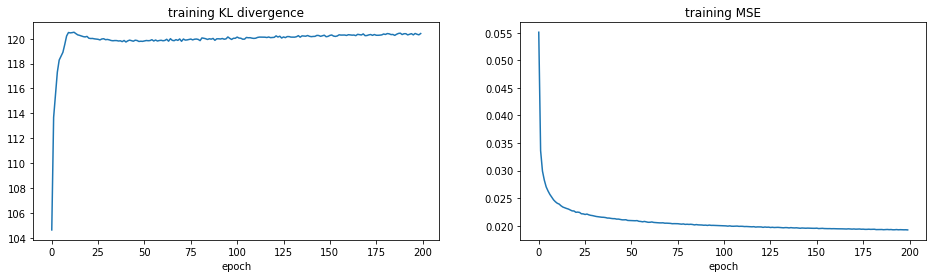

In [7]:
# store training log
with open("VAE_trainKLD.pkl", "wb") as f:
    pickle.dump(train_KLD, f)
with open("VAE_trainMSE.pkl", "wb") as f:
    pickle.dump(train_MSE, f)
    
# plot loss
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(train_KLD)
plt.title("training KL divergence")
plt.xlabel("epoch")

plt.subplot(1,2,2)
plt.plot(train_MSE)
plt.title("training MSE")
plt.xlabel("epoch")
plt.savefig("./VAE_output/fig1_2.jpg")
plt.show()

In [8]:
# visialize the latent space
input_X_test = Variable(test_X).cuda()
mu, logvar = model.encode(input_X_test)
#         print("mu shape",mu.size()," logvar",logvar.size())
latent_space = mu.cpu().data.numpy()

In [9]:
latent_embedded = TSNE(n_components=2, perplexity=30.0, random_state=38).fit_transform(latent_space)

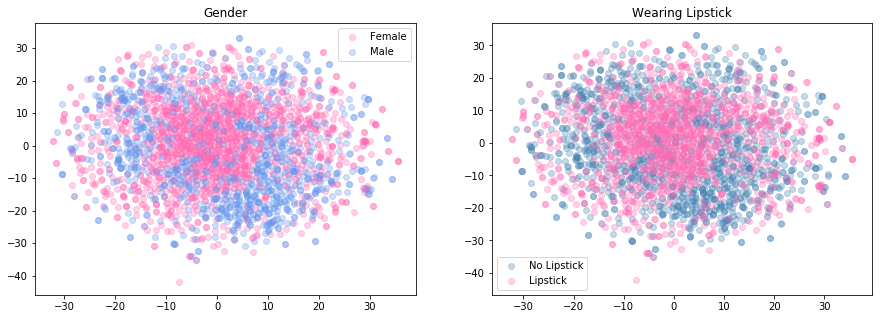

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
attr_arr = np.array(test_attr["Male"])
for i in [0,1]:
    if i==1:
        color="cornflowerblue"
        gender = "Male"
    else:
        color="hotpink"
        gender = "Female"
    xy = latent_embedded[attr_arr==i]
    label = attr_arr[attr_arr==i]
    ax1.scatter(xy[:,0], xy[:,1], c=color, label=gender,
               alpha=0.3)
ax1.legend()
ax1.set_title("Gender")
attr_arr = np.array(test_attr["Wearing_Lipstick"])
for i in [0,1]:
    if i==1:
        color="hotpink"
        gender = "Lipstick"
    else:
        color="steelblue"
        gender = "No Lipstick"
    xy = latent_embedded[attr_arr==i]
    label = attr_arr[attr_arr==i]
    ax2.scatter(xy[:,0], xy[:,1], c=color, label=gender,
               alpha=0.3)
ax2.legend()
ax2.set_title("Wearing Lipstick")
plt.savefig("./VAE_output/fig1_5.jpg")
plt.show()